In [4]:
# Update gensim to last version
!pip install gensim --upgrade

Objective: Find behaviour patterns in driver activities via clustering. (Manually) Classify this patterns to help recognize common faults while driving.

Example: Frequently missing B_T3 after a B_T2, making the hole sequence illegal.

Things worth considering:
- Variable length sequences.
- Activity representation. Possibilities:
  - activity, daytype, sequence, breaktype, token, legal -> [2,0,1,0,1]
  - Not sure if we should consider duration. In that case, should be normalized?
    - Maybe not because we are keeping token, and thus there would be redundant information
- Sequence representation. Possibilities:
  - List of activities (should span a day at most)
  - One activity at a time
  - Just one Sequence
- Distance function depends on the two previous points. Possibilities:
  - Substract duration and for the rest of variables only consider if they are the same. Probably different weights, as legal is more valuable.
- Categorical variables. We need to be careful with the distance function

---

Possible method:
1. Coding activities as word in a list representation
2. Group activities as sentences according to the Sequence column
3. Group sentences as documents, one for each driver
4. Apply sentence clustering or topic modelling (LDA?)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder

from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import corpus2dense, corpus2csc

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.cluster import KMeans

In [6]:
#########################################################################
# Load data
#########################################################################
data_path = "./combined-log.csv"
df = pd.read_csv(data_path, sep="\t",)

# To timestamp format
df.DateTimeStart = pd.to_datetime(df.DateTimeStart)
df.DateTimeEnd = pd.to_datetime(df.DateTimeEnd)

# Rename column
df = df_original = df.rename(columns={"#Driver":"Driver", "Duration(min)":"Duration"})


# To numerical
df.Legal = df.Legal.map({"yes": 1, "no": 0}) # Not sure if [-1,1] is better

# Drop columns
df = df.drop(columns=['Duration', 'ZenoInfo', "DateTimeStart", "DateTimeEnd", 'Week'])

df

,Driver,Activity,Day,DayType,Sequence,BreakType,Token,Legal
0,driver1,Break,1.0,ndd,first,split_1,B_T0,1
1,driver1,Driving,1.0,ndd,first,split_1,A,1
2,driver1,Other,1.0,ndd,first,split_1,A,1
3,driver1,Driving,1.0,ndd,first,split_1,A,1
4,driver1,Other,1.0,ndd,first,split_1,A,1
...,...,...,...,...,...,...,...,...
4170,driver25,Driving,13.0,ndd,unique,uninterrupted,A,1
4171,driver25,Other,13.0,ndd,unique,uninterrupted,A,1
4172,driver25,Driving,13.0,ndd,unique,uninterrupted,A,1
4173,driver25,Other,13.0,ndd,unique,uninterrupted,A,1


In [18]:
#########################################################################
# Transform data
# Encode each column as numeric and group them
#########################################################################

# The encoded columns are:
# Activity - DayType - Sequence - BreakType - Token - Legal

# Reorder columns
cols = ['Driver', 'Day', 'Activity', 'DayType', 'Sequence', 'BreakType', 'Token', 'Legal']
df = df[cols]

x = df.to_numpy()

# Encode into ordinal numbers
ordinalencoder_X = OrdinalEncoder(dtype=np.int8)
x[:,2:] = ordinalencoder_X.fit_transform(x[:,2:])

df_encoded = pd.DataFrame(x, columns=cols)

# Group columns into one (as string)
df_encoded['Encoding'] = df_encoded[df_encoded.columns[2:]].apply(
                            lambda x: '-'.join(x.dropna().astype(str)),
                            axis=1
                        )

# Remove encoded columns
df_encoded = df_encoded[['Driver','Day','Encoding']]

df_encoded

,Driver,Day,Encoding
0,driver1,1,0-1-0-1-1-1
1,driver1,1,1-1-0-1-0-1
2,driver1,1,3-1-0-1-0-1
3,driver1,1,1-1-0-1-0-1
4,driver1,1,3-1-0-1-0-1
...,...,...,...
4170,driver25,13,1-1-4-3-0-1
4171,driver25,13,3-1-4-3-0-1
4172,driver25,13,1-1-4-3-0-1
4173,driver25,13,3-1-4-3-0-1


In [19]:
# Group activities by day and join them in a list

# For each driver append all Encodings of one Day into a list
groups = df_encoded.groupby('Driver', sort=False) # False to keep driver ordering

# Each sentence is the sequence of activities in a day
corpus_lists = []

for name, group in groups:
  a = group.drop(columns='Driver')
  g = a.groupby('Day').cumcount()
  L = (a.set_index(['Day',g])
        .stack().groupby(level=0)
        .apply(lambda x: x.values))

  corpus_lists.extend(L)

In [20]:
print(len(df_encoded.Encoding.unique()))
df_encoded.Encoding.unique()

126


array(['0-1-0-1-1-1', '1-1-0-1-0-1', '3-1-0-1-0-1', '0-1-0-1-3-1',
       '1-1-0-2-0-1', '0-1-0-2-4-1', '1-1-2-3-0-1', '3-1-2-3-0-1',
       '0-1-2-3-5-1', '1-1-4-3-0-1', '3-1-4-3-0-1', '0-1-4-3-5-1',
       '1-0-0-1-0-1', '0-0-0-1-3-1', '1-0-0-2-0-1', '3-0-0-2-0-1',
       '0-0-0-2-4-1', '1-0-2-1-0-1', '0-0-2-1-3-1', '1-0-2-2-0-1',
       '0-0-2-2-4-1', '1-0-3-3-0-1', '3-0-3-3-0-1', '0-0-3-3-6-1',
       '1-0-2-3-0-1', '0-0-2-3-2-1', '1-0-3-1-0-1', '0-0-3-1-3-1',
       '1-0-3-2-0-1', '0-0-3-2-1-1', '0-0-3-2-5-1', '0-1-0-2-1-1',
       '3-1-0-2-0-1', '0-1-2-3-6-1', '1-1-0-3-0-1', '0-1-0-3-2-1',
       '1-1-2-1-0-1', '0-1-2-1-3-1', '1-1-2-2-0-1', '0-1-2-2-1-1',
       '0-1-2-2-5-1', '0-1-2-3-1-1', '0-1-2-3-10-1', '1-2-1-3-0-0',
       '3-2-1-3-0-0', '2-2-1-3-9-0', '0-2-1-3-2-0', '1-2-1-0-0-0',
       '2-2-1-0-9-0', '0-2-1-0-12-0', '0-2-1-0-1-0', '3-2-1-0-0-0',
       '1-1-4-1-0-1', '0-1-4-1-3-1', '1-1-4-2-0-1', '0-1-4-2-7-1',
       '0-1-4-3-10-1', '1-0-0-3-0-1', '0-0-0-3-1-1', '3-0-0-

In [21]:
#########################################################################
# Get embeddings
# Paragraph Vector (Doc2Vec)
# Word2vec for all the documents
#########################################################################

# Tag documents
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_lists)]

# Define and initialize model
doc2vec = Doc2Vec(documents, epochs=40, min_count=2, seed=1245)

# Train model
doc2vec.train(documents, 
              total_examples=doc2vec.corpus_count, 
              epochs=doc2vec.epochs)

In [22]:
# TODO: Evaluate doc2vec model

ranks = []
second_ranks = []
for doc_id in range(len(documents)):
    inferred_vector = doc2vec.infer_vector(documents[doc_id].words)
    sims = doc2vec.dv.most_similar([inferred_vector], topn=len(doc2vec.dv))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

import collections

counter = collections.Counter(ranks)
print(counter)

Counter({0: 58, 1: 19, 9: 14, 2: 14, 3: 11, 5: 11, 6: 7, 13: 7, 11: 7, 4: 6, 8: 6, 17: 5, 7: 5, 14: 5, 18: 4, 12: 4, 20: 4, 30: 3, 19: 3, 16: 3, 10: 3, 21: 2, 15: 2, 27: 2, 49: 2, 25: 2, 36: 2, 62: 2, 82: 1, 90: 1, 177: 1, 76: 1, 44: 1, 54: 1, 48: 1, 31: 1, 80: 1, 119: 1, 28: 1, 57: 1, 102: 1, 86: 1, 32: 1, 189: 1, 35: 1, 40: 1, 187: 1, 46: 1, 41: 1, 29: 1, 39: 1, 114: 1, 37: 1, 26: 1, 83: 1, 47: 1})


In [23]:
# Get embedding for each sentence
embeddings_d2v = []

for sentence in corpus_lists:
  embeddings_d2v.append(
      doc2vec.infer_vector(sentence)
  )

In [24]:
#########################################################################
# Get embeddings
# Bag-of-words and TF-IDF
# 
# It seem it will work without considering order (maybe because the tags already
# add information about it?)
# 
# https://stackoverflow.com/questions/50933591/how-to-perform-kmean-clustering-from-gensim-tfidf-values
#########################################################################

# Get the dictionary of our corpus
dictionary = Dictionary(corpus_lists)
num_docs = dictionary.num_docs
num_terms = len(dictionary.keys())

# Transform into bow (bag-of-words)
# It's a small dictionary so I think this representation shouldn't be a problem
corpus_bow = [dictionary.doc2bow(doc) for doc in corpus_lists]

# Transform into tf-idf (term frequency – inverse document frequency)
tfidf = TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

# Transform into sparse/dense matrix:
corpus_tfidf_dense = corpus2dense(corpus_tfidf, num_terms, num_docs)
# corpus_tfidf_sparse = corpus2csc(corpus_tfidf, num_terms, num_docs)

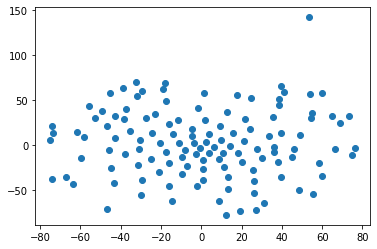

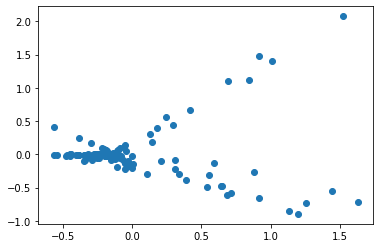

In [176]:
#########################################################################
# Visualize embeddings
#########################################################################

# TODO: HACERLO EN CONDICIONES

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(corpus_tfidf_dense)
df_1 = pd.DataFrame(X_tsne, columns=['x', 'y'])

fig, ax = plt.subplots()
ax.scatter(df_1['x'], df_1['y'])
plt.show()

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(corpus_tfidf_dense)
df_1 = pd.DataFrame(X_pca, columns=['x', 'y'])


fig, ax = plt.subplots()
ax.scatter(df_1['x'], df_1['y'])
plt.show()

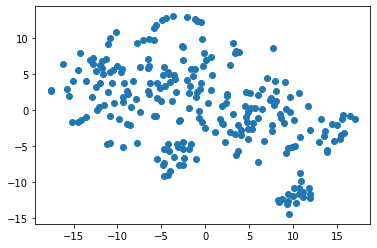

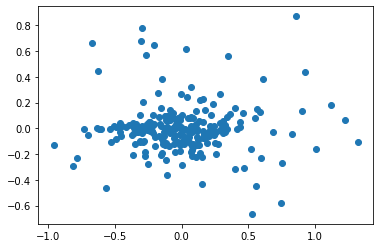

In [175]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(embeddings_d2v)
df_1 = pd.DataFrame(X_tsne, columns=['x', 'y'])

fig, ax = plt.subplots()
ax.scatter(df_1['x'], df_1['y'])
plt.show()

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(embeddings_d2v)
df_1 = pd.DataFrame(X_pca, columns=['x', 'y'])


fig, ax = plt.subplots()
ax.scatter(df_1['x'], df_1['y'])
plt.show()

In [122]:
#########################################################################
# Train data
# KMeans clustering
#########################################################################

n_clusters = 10

# Apply KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=12345)

clusters_bow = kmeans.fit_predict(corpus_tfidf_dense.T)  # Transposed!
centroid_bow = kmeans.cluster_centers_

clusters_d2v = kmeans.fit_predict(embeddings_d2v)
centroid_d2v = kmeans.cluster_centers_

print(clusters_bow)
print(clusters_d2v)

[2 5 0 3 2 9 7 2 6 4 7 0 0 1 5 8 8 4 5 0 2 3 5 4 3 2 9 6 1 9 6 5 2 7 9 0 9
 5 5 1 5 8 7 3 5 2 5 7 6 0 3 9 0 9 1 0 0 5 2 3 8 3 1 8 5 9 8 3 2 0 2 0 7 5
 9 9 6 0 5 7 0 8 1 6 4 3 1 8 5 5 6 7 5 0 0 9 6 9 3 5 4 7 7 6 3 9 4 4 6 4 1
 8 8 0 3 1 1 9 5 3 0 1 0 8 2 8 4 1 7 1 1 9 3 9 3 3 8 8 8 1 7 2 0 2 5 4 4 6
 2 4 0 3 4 9 6 6 3 8 7 4 5 5 7 3 0 9 8 1 5 7 9 5 7 5 2 3 7 7 2 5 0 3 8 4 7
 7 5 6 1 2 2 7 6 0 6 1 6 7 0 6 1 6 6 9 5 7 3 3 7 4 7 5 6 0 5 8 0 9 9 4 5 9
 2 3 3 7 4 4 1 6 2 7 6 2 0 8 1 1 0 2 5]
[2 3 2 1 5 4 2 5 1 3 1 8 9 4 2 5 0 6 2 8 1 1 3 0 1 2 1 1 5 2 1 2 1 5 2 1 1
 3 2 4 3 4 1 1 3 1 2 1 1 1 1 2 1 2 4 1 1 3 1 8 2 1 0 1 3 1 4 1 1 5 5 1 1 3
 2 1 1 1 3 4 1 1 5 1 6 6 4 4 3 2 1 2 3 1 2 1 1 1 1 1 8 5 1 1 2 1 6 1 2 1 4
 4 5 9 1 4 5 5 2 8 1 4 2 0 5 1 7 4 1 5 5 1 8 2 9 2 4 0 5 4 1 5 8 2 2 1 1 0
 5 6 0 8 6 1 1 1 1 2 1 9 2 3 4 2 1 2 1 1 2 1 2 3 4 2 5 1 4 1 1 3 2 1 5 0 1
 4 3 8 1 5 1 5 2 1 2 4 2 4 1 1 1 2 2 5 2 2 2 2 1 7 5 3 2 2 3 4 8 1 2 0 2 1
 1 2 1 1 5 8 4 1 5 1 1 1 8 4 5 1 2 5 2]


In [145]:
#########################################################################
# Train data
# DBscan clustering
#########################################################################

# The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped.
# https://scikit-learn.org/stable/modules/clustering.html#dbscan

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(metric='euclidean', eps=0.8, min_samples=2)
clusters_bow = dbscan.fit_predict(corpus_tfidf_dense.T)  # Transposed!
centroid_bow = dbscan.core_sample_indices_

dbscan = DBSCAN(metric='cosine', eps=0.1, min_samples=2)
clusters_d2v = dbscan.fit_predict(embeddings_d2v)
centroid_d2v = dbscan.core_sample_indices_

# Cluster = -1 -> Noise
print(clusters_bow)
print(clusters_d2v)

[ 0  1  2  3  0  0  0  0  4 -1  0  5  2  0  1  0  0 -1  1  2  0  6  1 -1
  7 -1  0  4 -1  0  4  1  0  0  0  5  0  1  1  0  8  0  0  7  1  0  1  0
  6  5 -1  0  5  0  0  2  5  1  0 -1  0  5  0  0  1  0  0  9  0  8  0  5
  0  1  0  0  4 10  1  0  5  0 -1  4  0  2  0  0  1  1  4  0  1  5 -1  0
  4  0  3  1  4  0  0  4  5  0  0 11 -1  0  0  0  0  5  5  0  0  0  1  5
 10  0  5  0  0  0  0  0  0  0 -1  0 12  0  7  3 -1  0  0  0  0  0  2  0
  1 -1  0 -1  0  4 -1  7  4  0  4  4  7  0  0 11  1  1 -1 12  2 -1  0  0
  1  0  0  1  0  1  0  9  0  0  0  1  5  5  0  0  0  0  1  4  0  0  0  0
  4  5  4  0  4  0  5  4  0  4  4  0  1  0 12 -1  0  0  0  1  6  2  1  0
  2  0  0 -1  1  0  0  6  2  0 13 13  0 -1  0  0  4  0  5  0  0  0  5  0
  1]
[-1  0  0 -1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0 -1  0 -1
  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0  1 -1  0  0  0  0  0  0  0  0
 -1  0  0 -1  0  2  0  0  0  0  0  0 -1 -1 -1 -1  0  0 -1  0  0  0  0  0
  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0 

In [112]:
#########################################################################
# Get decoded centroids for Doc2Vec
#########################################################################

# Receives an encoding
def undo_encoding(x):
  l = x.split('-')
  return [int(e) for e in l]

# Receives a document
def v_undo_encoding(x):
  return [undo_encoding(e) for e in x]

# ------------------------------------------------------------------------------

def get_decoded_centroids_d2v(centroids):
  # For each centroid get the most similar document
  centroid_docs = []
  for cent in centroids:
    doc, similarity = doc2vec.dv.most_similar(positive = [cent], topn=1)[0]
    centroid_docs.append(doc)

  # Get the content of each doc
  docs = []
  for c_doc in centroid_docs:
    docs.append(corpus_lists[c_doc])

  # -----------------------------------------------

  # Get input format for inverse_encoder
  encoded_centroids = list(map(v_undo_encoding, docs))

  # Decode each centroid
  decoded_centroids = []
  for centroid in encoded_centroids:
    b = ordinalencoder_X.inverse_transform(centroid)
    
    decoded_centroids.append(b)

  # -----------------------------------------------
  # Get centroids as DataFrame

  cols = ['Activity', 'DayType', 'Sequence', 'BreakType', 'Token', 'Legal']

  df_centroids = pd.DataFrame(columns=cols)

  for c, number in zip(decoded_centroids, range(len(decoded_centroids))):
    df_c = pd.DataFrame(c, columns=cols)
    df_c["Cluster"] = number

    df_centroids = df_centroids.append(df_c)

  return df_centroids

In [113]:
decoded_centroids_d2v = get_decoded_centroids_d2v(centroid_d2v)
decoded_centroids_d2v

,Activity,DayType,Sequence,BreakType,Token,Legal,Cluster
0,Driving,none,none,split_1,A,0,0.0
1,Break,none,none,split_1,B_T2,0,0.0
2,Driving,none,none,split_2,A,0,0.0
3,Break,none,none,split_2,B_T3,0,0.0
4,Driving,ndd,first,split_1,A,1,0.0
...,...,...,...,...,...,...,...
9,Driving,ndd,second,split_1,A,1,9.0
10,Break,ndd,second,split_1,B_T2,1,9.0
11,Driving,ndd,second,split_2,A,1,9.0
12,Other,ndd,second,split_2,A,1,9.0


In [ ]:
# Print results

# NOTE: Select here which clusters show
clusters = clusters_d2v

groups = df2.groupby(['Driver','Day'], sort=False)

results = []
for (name, group), cluster in zip(groups, clusters):
  results.append("{} in day {}: {}".format(name[0], int(name[1]), cluster))

# results

In [120]:
#########################################################################
# Save results
#########################################################################

# NOTE: Select here which clusters save
clusters = clusters_d2v

# Final dataset columns
cols = df_original.columns.to_numpy()
cols = np.insert(cols, -1, 'Cluster')

df_out = pd.DataFrame(columns=cols)

groups = df_original.groupby(['Driver','Day'], sort=False)

# Add clusters to log
for (name, group), cluster in zip(groups, clusters):
  group["Cluster"] = cluster
  df_out = df_out.append(group)

df_out

,Driver,DateTimeStart,DateTimeEnd,Duration,Activity,Week,Day,DayType,Sequence,BreakType,Token,Legal,Cluster,ZenoInfo
0,driver1,2017-02-01 17:59:00,2017-02-01 18:13:00,14.0,Break,1.0,1.0,ndd,first,split_1,B_T0,1,2,NaN
1,driver1,2017-02-01 18:13:00,2017-02-01 18:16:00,3.0,Driving,1.0,1.0,ndd,first,split_1,A,1,2,NaN
2,driver1,2017-02-01 18:16:00,2017-02-01 18:18:00,2.0,Other,1.0,1.0,ndd,first,split_1,A,1,2,NaN
3,driver1,2017-02-01 18:18:00,2017-02-01 18:20:00,2.0,Driving,1.0,1.0,ndd,first,split_1,A,1,2,NaN
4,driver1,2017-02-01 18:20:00,2017-02-01 18:43:00,23.0,Other,1.0,1.0,ndd,first,split_1,A,1,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4170,driver25,2017-01-15 09:56:00,2017-01-15 09:59:00,3.0,Driving,3.0,13.0,ndd,unique,uninterrupted,A,1,2,NaN
4171,driver25,2017-01-15 09:59:00,2017-01-15 10:01:00,2.0,Other,3.0,13.0,ndd,unique,uninterrupted,A,1,2,NaN
4172,driver25,2017-01-15 10:01:00,2017-01-15 10:08:00,7.0,Driving,3.0,13.0,ndd,unique,uninterrupted,A,1,2,NaN
4173,driver25,2017-01-15 10:08:00,2017-01-15 10:12:00,4.0,Other,3.0,13.0,ndd,unique,uninterrupted,A,1,2,NaN


In [121]:
# Save as CSV
df_out.to_csv("log-clustering.csv", sep="\t", index=False)

# Download
from google.colab import files
files.download("log-clustering.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save each cluster separated
groups = df_out.groupby(['Cluster'], sort=False)

# Add clusters to log
for name, group in groups:
  cluster = group['Cluster'].to_numpy()[0]
  
  path = "log-clustering-c{}.csv".format(cluster)
  group.to_csv(path, sep="\t", index=False)
  files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [118]:
# Save d2v centroids
decoded_centroids_d2v.to_csv("log-clustering-centroids.csv", sep="\t", index=False)
files.download("log-clustering-centroids.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>